In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xgcm import Grid
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
warnings.filterwarnings('ignore')
import os
import gc

In [3]:
from dask.distributed import Client
client = Client(n_workers=6,
                threads_per_worker=1,
                memory_limit='24GB')
client

<Client: 'tcp://127.0.0.1:33917' processes=6 threads=6, memory=134.11 GiB>

We first extract one time step of SOSE data, here the second 5days output of year 2024.

In [ ]:
#PATH = "/gws/nopw/j04/co2clim/datasets/bSOSE/ITER156/"
#year='2024'
#os.listdir(PATH+year)

In [ ]:
ds_TTEND_TOT = xr.open_dataset(PATH +f'{year}/TOTTTEND_bsoseI156_{year}_5day.nc')
ds_TTEND = ds_TTEND_TOT.isel(time=slice(1,2))
del(ds_TTEND_TOT)

ds_STEND_TOT = xr.open_dataset(PATH +f'{year}/TOTSTEND_bsoseI156_{year}_5day.nc')
ds_STEND = ds_STEND_TOT.isel(time=slice(1,2))
del(ds_STEND_TOT)

ds_ADV_TOT   = xr.open_mfdataset([PATH +f'{year}/ADVx_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVy_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVr_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVx_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVy_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/ADVr_SLT_bsoseI156_{year}_5day.nc'])
ds_ADV = ds_ADV_TOT.isel(time=slice(1,2))
del(ds_ADV_TOT)

ds_DIFF_TOT  = xr.open_mfdataset([PATH +f'{year}/DFxE_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFyE_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFrI_TH_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFxE_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFyE_SLT_bsoseI156_{year}_5day.nc',
                                  PATH +f'{year}/DFrI_SLT_bsoseI156_{year}_5day.nc'])
ds_DIFF = ds_DIFF_TOT.isel(time=slice(1,2))
del(ds_DIFF_TOT)

ds_FWFLUX_TOT = xr.open_dataset(PATH + f'{year}/oceFWflx_bsoseI156_{year}_5day.nc')
ds_FWFLUX = ds_FWFLUX_TOT.isel(time=slice(1,2))
del(ds_FWFLUX_TOT)

ds_TFLUX_TOT = xr.open_dataset(PATH + f'{year}/surfTflx_bsoseI156_{year}_5day.nc')
ds_TFLUX = ds_TFLUX_TOT.isel(time=slice(1,2))
del(ds_TFLUX_TOT)

ds_SW_TOT    = xr.open_dataset(PATH + f'{year}/oceQsw_bsoseI156_{year}_5day.nc')
ds_SW = ds_SW_TOT.isel(time=slice(1,2))
del(ds_SW_TOT)

ds_THETA_TOT = xr.open_dataset(PATH + f'{year}/Theta_bsoseI156_{year}_5day.nc')
ds_THETA = ds_THETA_TOT.isel(time=slice(1,2))
del(ds_THETA_TOT)

ds_SALT_TOT  = xr.open_dataset(PATH + f'{year}/Salt_bsoseI156_{year}_5day.nc')
ds_SALT = ds_SALT_TOT.isel(time=slice(1,2))
del(ds_SALT_TOT)

ds_SFLUX_TOT = xr.open_dataset(PATH + f'{year}/surfSflx_bsoseI156_{year}_5day.nc')
ds_SFLUX = ds_SFLUX_TOT.isel(time=slice(1,2))
del(ds_SFLUX_TOT)

ds_VEL_TOT   = xr.open_mfdataset(PATH +f'{year}/*velMass_bsoseI156_{year}_5day.nc')
ds_VEL = ds_VEL_TOT.isel(time=slice(1,2))
del(ds_VEL_TOT)

ds_SNAPS_TOT = xr.open_mfdataset([PATH + f'{year}/Theta_bsoseI156_{year}_5daySnaps.nc',
                                  PATH + f'{year}/Salt_bsoseI156_{year}_5daySnaps.nc'])
ds_SNAPS = ds_SNAPS_TOT.isel(time=slice(1,2))
del(ds_SNAPS_TOT)


In [ ]:
ds_SSH_TOT    = xr.open_dataset(PATH + f'{year}/SSH_bsoseI156_{year}_5daySnaps.nc')
ds_SSH = ds_SSH_TOT.isel(time=1)

In [ ]:
ds_SNAPS = ds_SNAPS.rename({"THETA":"THETA_SNAPS","SALT":"SALT_SNAPS"})

In [ ]:
ds_tot=xr.merge([ds_TTEND,ds_STEND,ds_ADV,ds_DIFF,ds_TFLUX,ds_FWFLUX,ds_SFLUX,ds_SW,ds_THETA,ds_SALT,ds_VEL,ds_SNAPS])
ds_tot

In [ ]:
ds = ds_tot.isel(time=0)

In [ ]:
ds.to_netcdf("./SOSE_2024-01-08_5days.nc")

In [4]:
#gc.collect()
ds = xr.open_dataset("./SOSE_2024-01-08_5days.nc")

The dataset `ds` contains all diagnostics required to close the mass, heat and salt budgets

In [5]:
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at center
ds['CV']= ds.rA * ds.drC # Cell volume 
ds['rAW'] = ds.dyG * ds.drW # cell side areas at u location
ds = ds.set_coords( ("drW","drS","drC","CV","rAW") )

metrics = {
        ('X',): ['dxC', 'dxG'], # X distances
        ('Y',): ['dyC', 'dyG'], # Y distances
        ('Z',): ['drF','drW', 'drS', 'drC'], # Z distances
        ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
    }

coords={'X': {'center': 'XC', 'left': 'XG'},
        'Y': {'center': 'YC', 'left': 'YG'},
        'Z': {'center': 'Z', 'left': 'Zl'}}

grid = Grid(ds,  periodic=['X'], coords=coords, metrics = metrics, boundary={'X':'periodic','Y':'extend','Z':'fill'}, fill_value=0)
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary='extend'):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary='fill'):
  * center   Z --> left
  * left     Zl --> center

In [6]:
rho_0 = 1035.     # kg/m3
Cp = 3992.        # J/kg/K
g_to_kg = 0.001  
day_per_second = 1/86400.

In [7]:
mask2D = (1.-ds.maskInC).isel(YC=slice(0,587))
land = (mask2D == 1).isel(YC=slice(0,587))

### Mass budget ###

The computation is Boussinesq, so the mass budget should be equivalent to the zero divergence equation:
$$ 
\nabla \cdot (\rho_0 \vec{u}) = 0 
$$
Integrating over one cell, this yields:
$$
\rho_0  (dSx_{i+1}U_{i+1} - dSx_i U_i) + (dSy_{j+1}V_{j+1} - dSy_j V_j) + (dSz_k W_k - dSz_{k+1}W_{k+1}) 
$$
i, j, k are the zonal, meridional and vertical indices, respectively. \
U, V, W are the zonal, meridional and vertical velocity fields, respectively. \
dSx, dSy, dSz are the associated cell areas.

We compute these terms in the following.

In [8]:
# ignore this cell

#fig,axs=plt.subplots(1,1,figsize=(10,10))
ds["rhoRefZl"]=grid.interp(ds.rhoRef,'Z')
ds["rhoRefZl"][0]=1020.955
#ds.rhoRefZl.isel(Zl=slice(0,10)).plot.line(ax=axs,marker='o')
#ds.rhoRef.isel(Z=slice(0,10)).plot.line(ax=axs,marker='o')

In [9]:
# Compute the mass transports
grid._ds["UTRANS"] = ds["UVELMASS"] * ds.dyG * ds.drF * rho_0
grid._ds["VTRANS"] = ds["VVELMASS"] * ds.dxG * ds.drF * rho_0
grid._ds["WTRANS"] = ds["WVELMASS"] * ds.rA * rho_0

In [10]:
# Compute zonal divergence of zonal transport
DIFFUTRANS=grid.diff(ds['UTRANS'],'X') 

In [11]:
# Compute meridional divergence of meridional transport
DIFFVTRANS=grid.diff(ds['VTRANS'],'Y',boundary = 'extend') 

In [12]:
# Compute vertical divergence of vertical transport
DIFFWTRANS=grid.diff(ds['WTRANS'],'Z',boundary = 'fill', fill_value = 0)

In [13]:
# Sum to obtain divergence
DIV = DIFFUTRANS + DIFFVTRANS - DIFFWTRANS 

In [14]:
# Vertically sum these terms
DIV2D = DIV.sum('Z')
DIFFUTRANS2D = DIFFUTRANS.sum('Z')
DIFFVTRANS2D = DIFFVTRANS.sum('Z')
DIFFWTRANS2D = DIFFWTRANS.sum('Z')

In [15]:
DIV2D = DIV2D.rename("DIV")

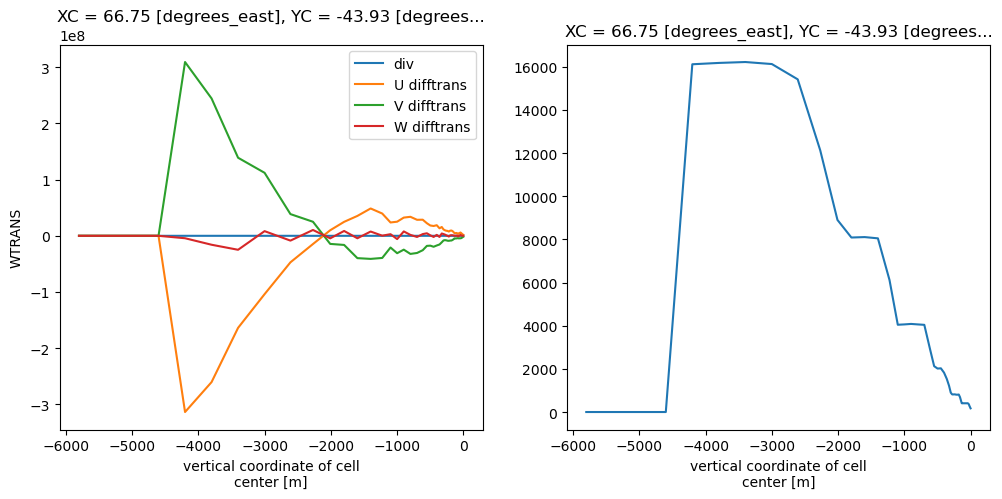

In [16]:
# Vertical profile of the mass budget (open ocean location) 
ix=400
iy=480
fig,axs=plt.subplots(1,2,figsize=(12,5))
DIV.isel(XC=ix,YC=iy).plot(ax=axs[0],label='div')
DIFFUTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='U difftrans')
DIFFVTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='V difftrans')
DIFFWTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='W difftrans') 
DIV.isel(XC=ix,YC=iy).plot(ax=axs[1])
axs[0].legend();

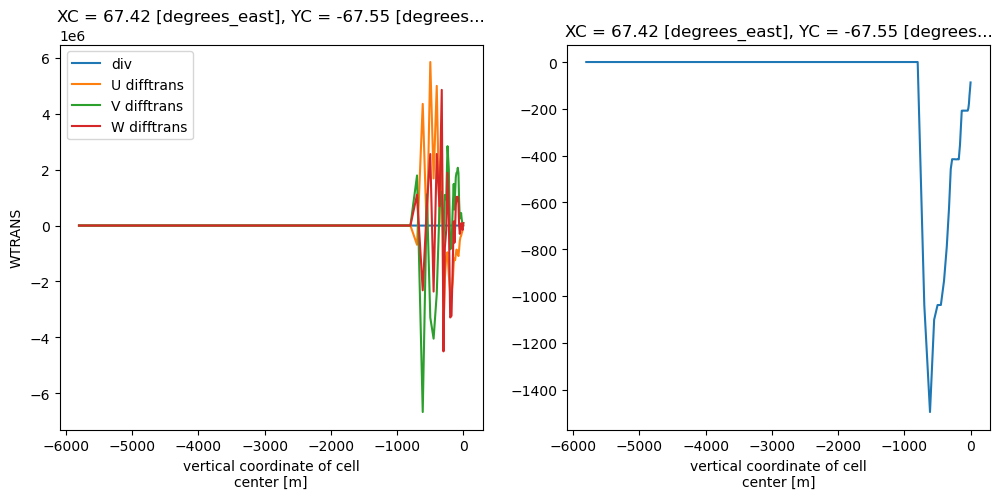

In [17]:
# Vertical profile of the mass budget (shelf location) 
ix=404
iy=218
fig,axs=plt.subplots(1,2,figsize=(12,5))
DIV.isel(XC=ix,YC=iy).plot(ax=axs[0],label='div')
DIFFUTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='U difftrans')
DIFFVTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='V difftrans')
DIFFWTRANS.isel(XC=ix,YC=iy).plot(ax=axs[0],label='W difftrans') 
DIV.isel(XC=ix,YC=iy).plot(ax=axs[1])
axs[0].legend();

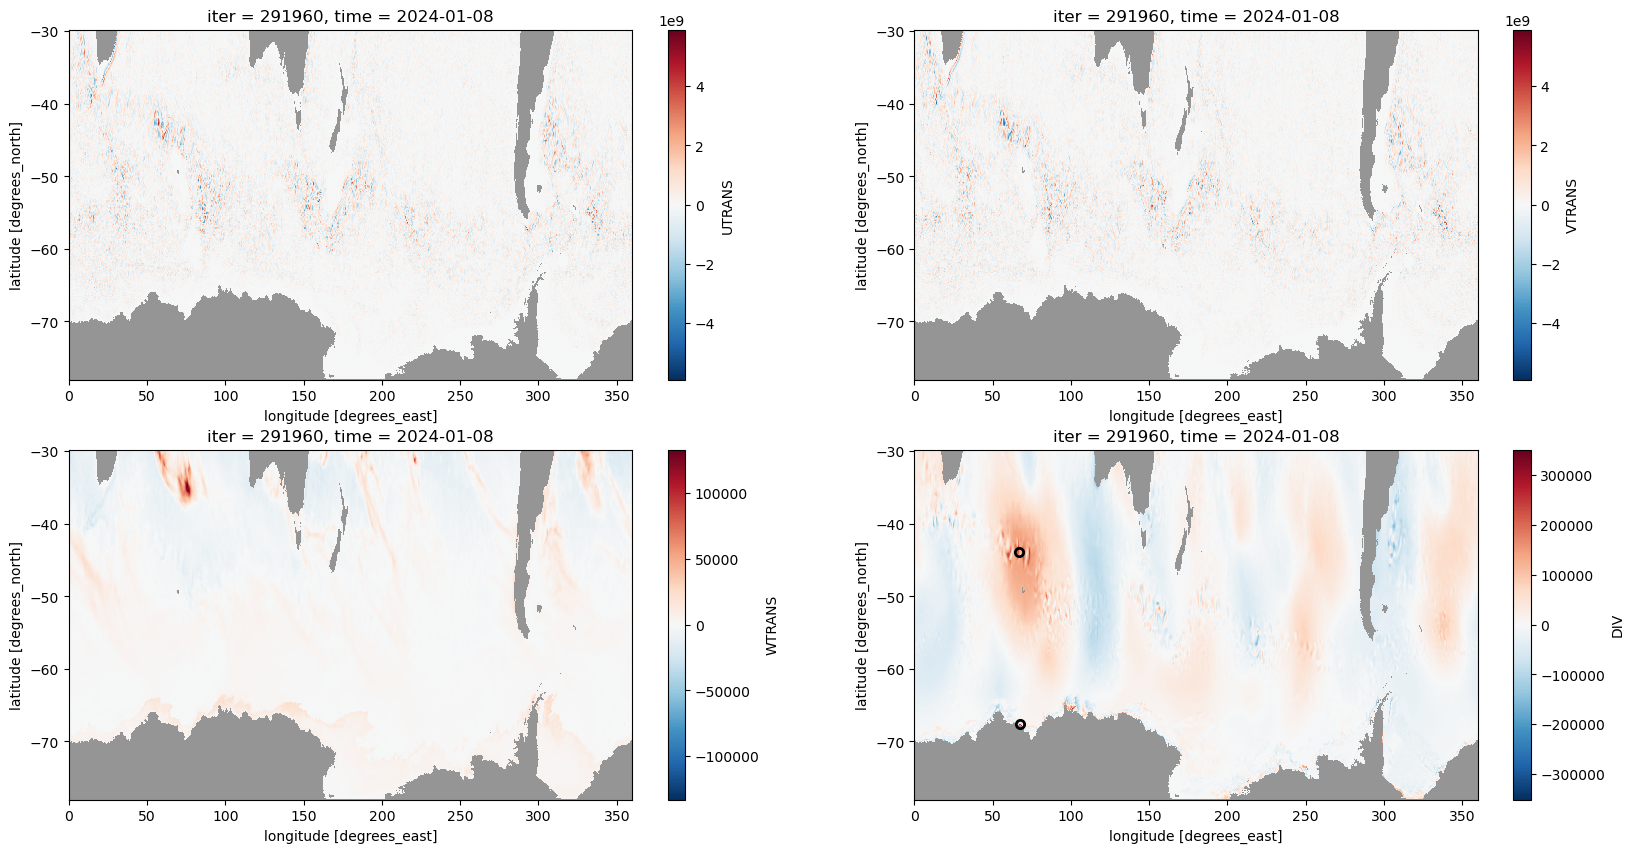

In [18]:
# plot vertically integrated terms

fig,axs=plt.subplots(2,2,figsize=(20,10))

land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFFUTRANS2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])

land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFFVTRANS2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])

land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFFWTRANS2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])

land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIV2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,1])

# location of the vertical profiles on the DIV plot
axs[1,1].plot(67.42,-67.61,'o',markeredgewidth=2,markeredgecolor='black',markerfacecolor='None' )
axs[1,1].plot(66.75,-43.93,'o',markeredgewidth=2,markeredgecolor='black',markerfacecolor='None' );

We see here that the mass budget doesn'y exactly close, with a vertically integrated remainder exhibiting a large scale pattern.

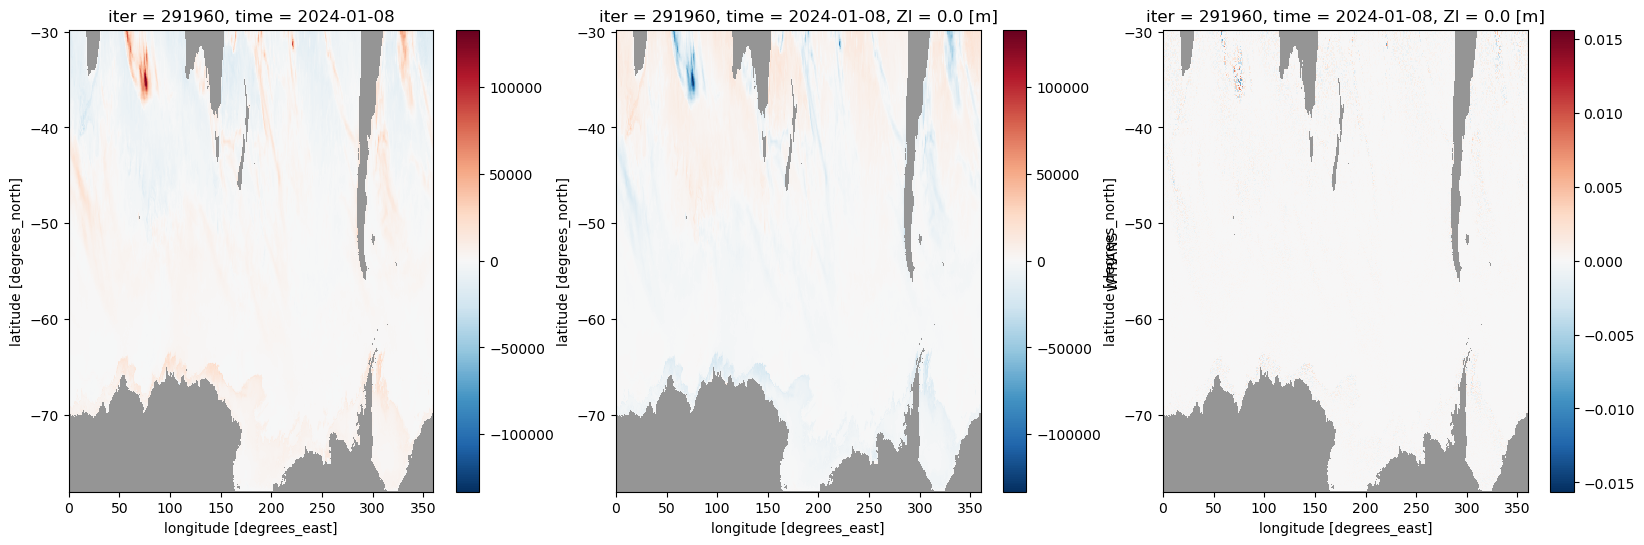

In [19]:
# Show that the vertical mass transport at the surface is equal to (minus) the net fresh water flux at the surface
# the difference is about 7 orders of magnitude less than the terms, which is expected with single precision output
fig,axs=plt.subplots(1,3,figsize=(20,6))

land.plot(ax=axs[0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds.oceFWflx*ds.rA).where(mask2D == 0).plot(ax=axs[0])
land.plot(ax=axs[1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds['WTRANS'].isel(Zl=0)).where(mask2D == 0).plot(ax=axs[1])
land.plot(ax=axs[2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
(ds.oceFWflx*ds.rA + ds['WTRANS'].isel(Zl=0)).where(mask2D == 0).plot(ax=axs[2]);

### Heat budget ###

The heat budget should be:
$$
\frac{d ( \text{Heat content})}{d t} = \text{ADVECTION} + \text{DIFFUSION} + \text{SHORT WAVE HEATING} + \text{SURFACE NON SW HEATING}
$$

But we saw that the divergence is non-zero, so we have to add the divergence contribution, which is:
$$
\text{DIV}_{\text{Heat}} = C_p \text{DIV}_{\text{Mass}} \theta
$$
With $\theta$ the potential temperature, $C_p = 3992 J/kg/C$ the specific heat capacity of sea water 

Note that some of the outputted diagnostics indicate temperature tendencies (tracer concentration tendencies). We want to close the budget for tracer content (total cell heat content), thus we multiply ADV and DIFF by $\rho_0 \times C_p$ and the Eulerian temperature tendency by $\text{VOLUME} \times \rho_0 \times C_p$

We compute these terms in the following.

In [20]:
ADV_TH = - (grid.diff(ds['ADVx_TH'],'X') 
            + grid.diff(ds['ADVy_TH'],'Y',boundary = 'extend') 
            - grid.diff(ds['ADVr_TH'],'Z',boundary = 'fill', fill_value = 0) ) * rho_0 * Cp
ADV_TH = ADV_TH.rename('ADV_TH')

In [21]:
DIFF_TH = - (  grid.diff(ds['DFxE_TH'],'X')  
          + grid.diff(ds['DFyE_TH'],'Y',boundary = 'extend')  
          - grid.diff(ds['DFrI_TH'],'Z',boundary = 'fill', fill_value = 0) ) * rho_0 * Cp
DIFF_TH = DIFF_TH.rename('DIFF_TH')

In [22]:
# The short wave heating term demands a bit of work

Zlp1 = np.concatenate([ds.Zl.values,[-6000.]])
q1 = 0.62 * np.exp(Zlp1[:-1]/0.6) + (1-0.62) * np.exp(Zlp1[:-1]/20.0) 
q2 = 0.62 * np.exp(Zlp1[1:]/0.6) + (1-0.62) * np.exp(Zlp1[1:]/20.0)

# Correction for the 200m cutoff
zCut = np.where(ds.Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[ds.Z],dims=['Z'])
q2 = xr.DataArray(q2,coords=[ds.Z],dims=['Z'])
landmask = ds.hFacC.copy(deep=True).compute()
landmask.values[landmask.values > 0] = 1
SF = (ds['TFLUX'] - (1-q1[0]+q2[0])*ds['oceQsw']) * landmask.isel(Z=0) * ds.rA
## Calculate subsurface shortwave radiation penetration 
SBSFQSW = ((q1 * (landmask == 1)-q2*(landmask.shift(Z=-1)==1))*ds['oceQsw']).rename('QSW')
SBSFQSW.values[SBSFQSW.Z == -2.1] = 0 
SBSFQSW = SBSFQSW * ds.rA

In [23]:
maskZ = xr.DataArray(np.zeros(len(ds['Z'])),dims=['Z'],coords={'Z':ds['Z']})
maskZ[0] = 1 

In [24]:
# Switch from degC/day to J/s
HEAT_TEND = ds["TOTTTEND"] * ds.rA * ds.drC * rho_0 * Cp * day_per_second
HEAT_TEND = HEAT_TEND.rename('HEAT_TEND')

In [25]:
SF3D=SF*maskZ

In [26]:
DIV_TH = DIV*ds.THETA*Cp

In [27]:
# Here compute the heat budget first with, then without the divergence term

RES =  HEAT_TEND - ADV_TH - DIFF_TH - SF * maskZ - SBSFQSW  - DIV_TH
RESBIS =  HEAT_TEND - ADV_TH - DIFF_TH - SF * maskZ - SBSFQSW

In [28]:
RES2D = RES.sum('Z')
RESBIS2D = RESBIS.sum('Z')
HEAT_TEND2D = HEAT_TEND.sum('Z')
ADV_TH2D = ADV_TH.sum('Z')
SBSFQSW2D = SBSFQSW.sum('Z')
DIFF_TH2D = DIFF_TH.sum('Z')
DIV_TH2D = DIV_TH.sum('Z')

In [29]:
SBSFQSW2D = SBSFQSW2D.rename("Short wave")
SF = SF.rename("non-SW heat flux")
DIV_TH2D = DIV_TH2D.rename("divergence term")
RES2D = RES2D.rename("Residual")
RESBIS2D = RESBIS2D.rename("Residual without div term")

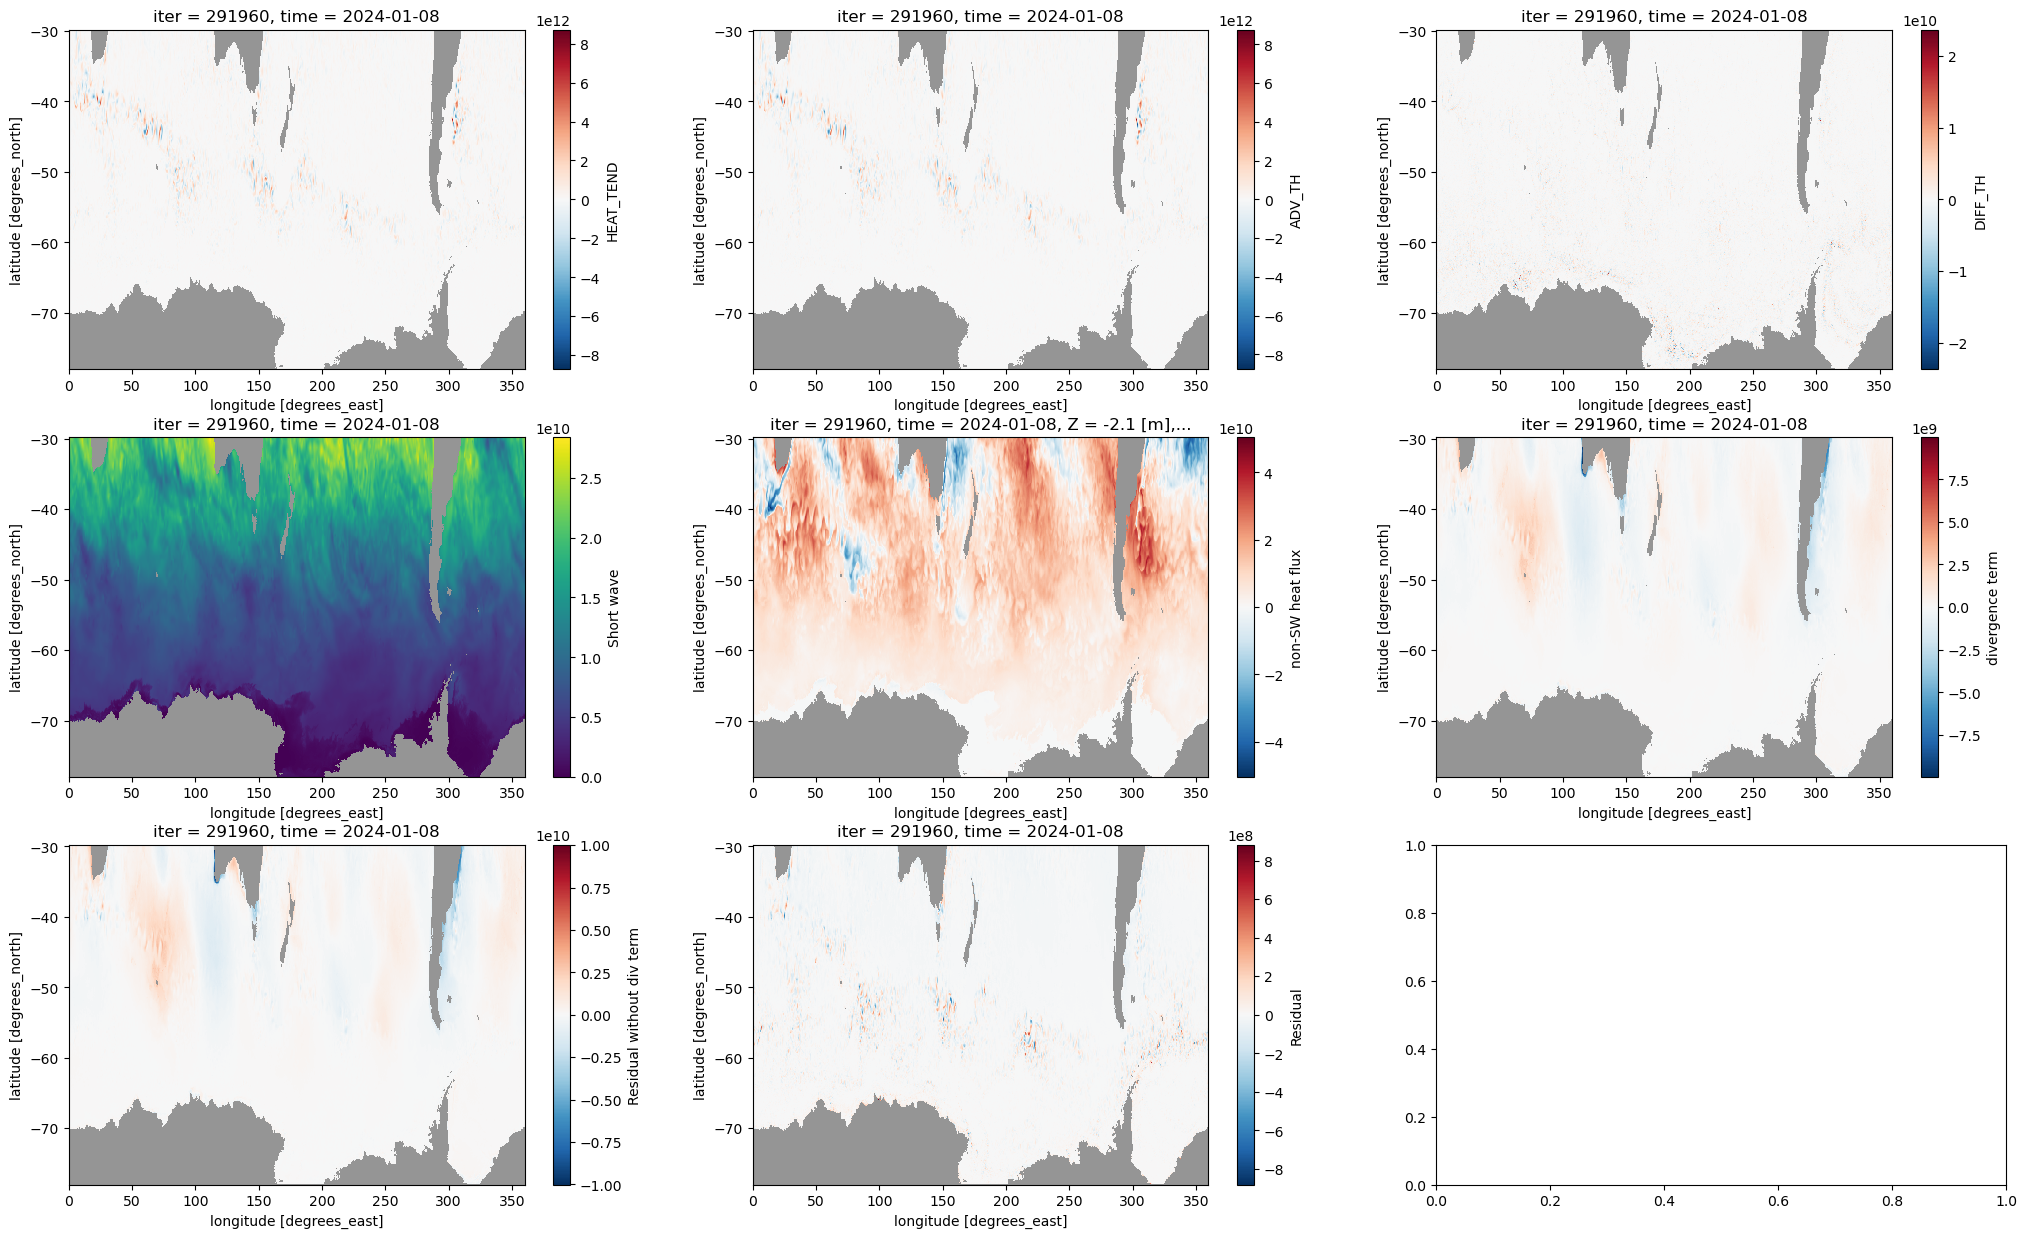

In [30]:
fig,axs=plt.subplots(3,3,figsize=(25,15))

land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
HEAT_TEND2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])
land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ADV_TH2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])
land.plot(ax=axs[0,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFF_TH2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,2])
land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SBSFQSW2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])
land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SF.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,1])
land.plot(ax=axs[1,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIV_TH2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,2])
land.plot(ax=axs[2,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RESBIS2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[2,0])
land.plot(ax=axs[2,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[2,1]);

We observe that the "heat divergence" exhibits the same pattern as the mass divergence, and that taking it into account in the budget improves it by an order of magnitude.

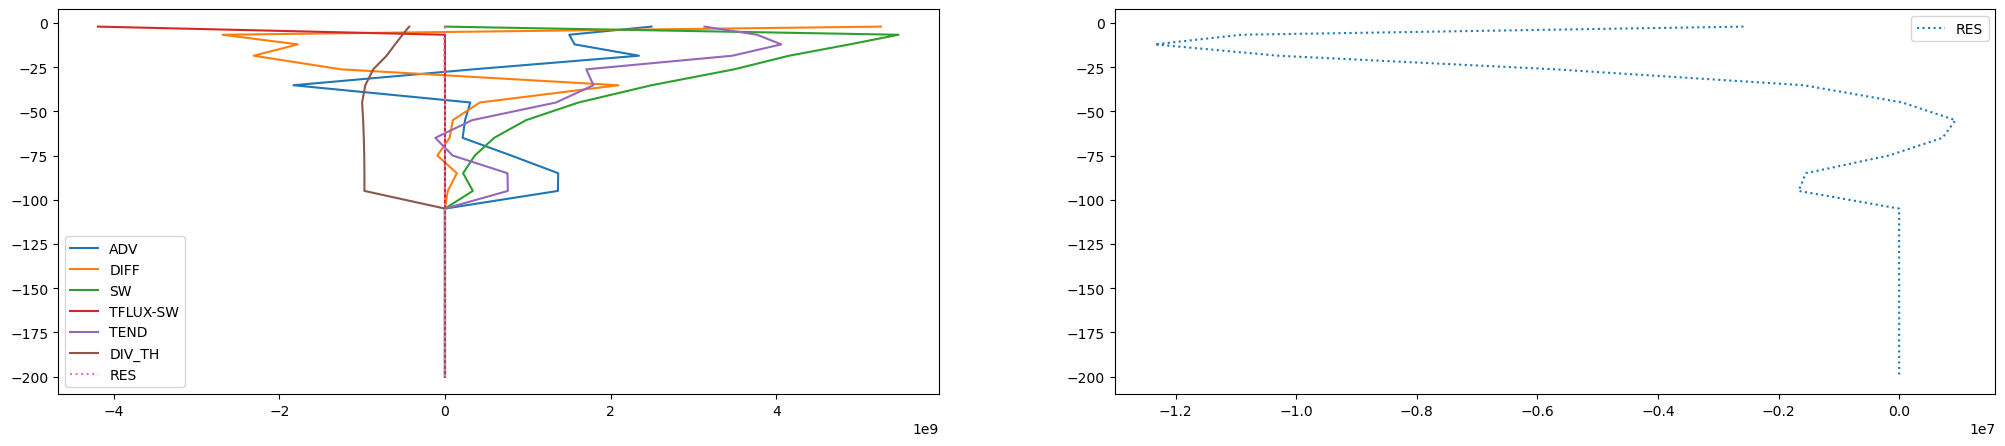

In [31]:
# Heat budget example vertical profile
# Observe the non-negligibility of the heat divergence term
iy = 562
ix = 693
fig, axs = plt.subplots(1,2,figsize=(25,5))
axs[0].plot(ADV_TH.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'ADV')
axs[0].plot(DIFF_TH.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'DIFF')
axs[0].plot(SBSFQSW.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'SW')
axs[0].plot(SF3D.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'TFLUX-SW')
axs[0].plot(HEAT_TEND.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'TEND')
axs[0].plot(DIV_TH.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'DIV_TH')
axs[0].plot(RES.isel(XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'RES',linestyle = ':')
axs[1].plot(RES.isel(XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'RES',linestyle = ':')
axs[0].legend()
axs[1].legend()
plt.show()

### Salt budget ###

Taking into account the "salt divergence term", the salt budget should be:
$$
\frac{d ( \text{Salt content})}{d t} = \text{ADVECTION} + \text{DIFFUSION} + \text{SURFACE SALT FLUX} + \text{DIV}_{\text{Salt}}
$$
with
$$
\text{DIV}_{\text{Salt}} = 0.001 \times \text{DIV}_{\text{Mass}} \times S
$$
With $S$ the salinity, the 0.001 multiplication converting from grams of salt to kilograms of salt.  

Again, we want the budgets to be made in tracer content (salt) and not in tracer concentration (salinity).

We compute these terms in the following.

In [32]:
ADV_SLT = - (grid.diff(ds['ADVx_SLT'],'X') 
            + grid.diff(ds['ADVy_SLT'],'Y',boundary = 'extend') 
            - grid.diff(ds['ADVr_SLT'],'Z',boundary = 'fill', fill_value = 0) ) * rho_0 * g_to_kg
ADV_SLT = ADV_SLT.rename('ADV_SLT')

In [33]:
DIFF_SLT = - (  grid.diff(ds['DFxE_SLT'],'X')  
          + grid.diff(ds['DFyE_SLT'],'Y',boundary = 'extend')  
          - grid.diff(ds['DFrI_SLT'],'Z',boundary = 'fill', fill_value = 0) ) * rho_0 * g_to_kg
DIFF_SLT = DIFF_SLT.rename('DIFF_SLT')

In [34]:
SALT_TEND = ds["TOTSTEND"] * ds.rA * ds.drC * rho_0 * g_to_kg * day_per_second
SALT_TEND = SALT_TEND.rename('SALT_TEND')

In [35]:
SALTFLX = ds["SFLUX"] * ds.rA * g_to_kg * maskZ

In [36]:
DIV_SALT = DIV * ds.SALT * g_to_kg

In [37]:
RES =  SALT_TEND - ADV_SLT - DIFF_SLT - SALTFLX - DIV_SALT

In [38]:
RES2D = RES.sum('Z')
SALT_TEND2D = SALT_TEND.sum('Z')
ADV_SLT2D = ADV_SLT.sum('Z')
SALTFLX2D = SALTFLX.sum('Z')
DIFF_SLT2D = DIFF_SLT.sum('Z')
DIV_SALT2D = DIV_SALT.sum('Z')


In [39]:
SALTFLX2D = SALTFLX2D.rename("Salt surf flux")
DIV_SALT2D = DIV_SALT2D.rename("rho_0.div(U).S")
RES2D = RES2D.rename("Residual")

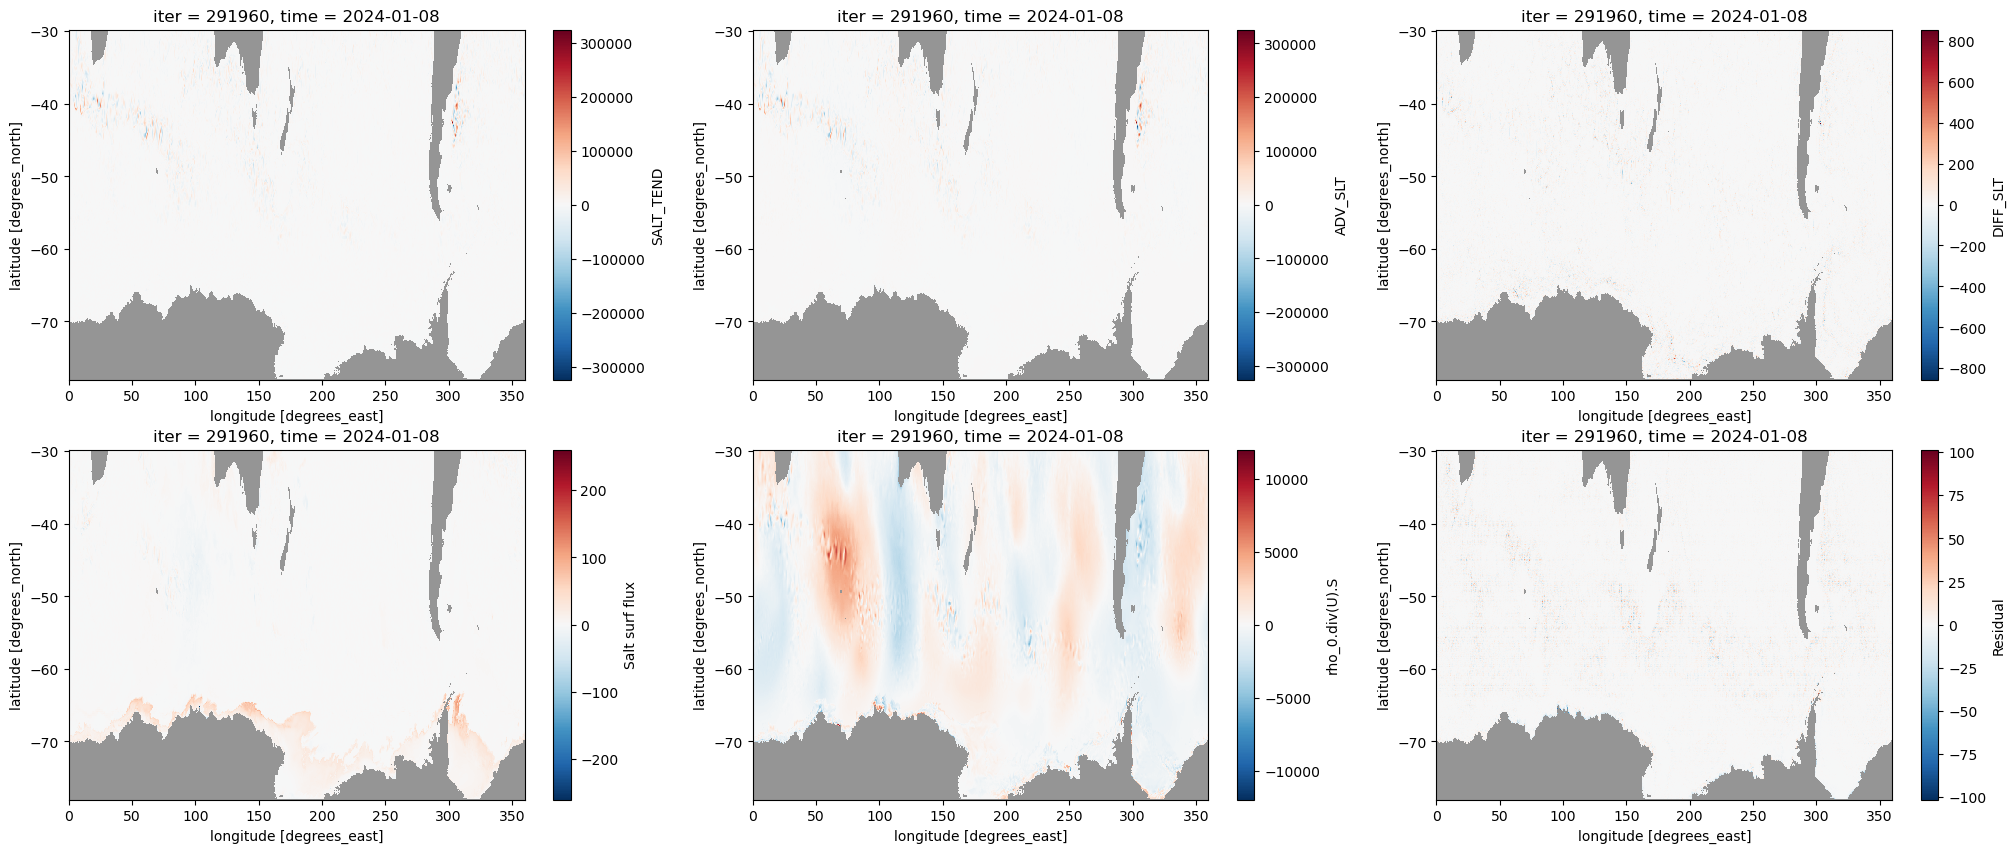

In [40]:
fig,axs=plt.subplots(2,3,figsize=(25,10))
land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SALT_TEND2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,0])
land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ADV_SLT2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,1])
land.plot(ax=axs[0,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIFF_SLT2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[0,2])
land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
SALTFLX2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,0])
land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
DIV_SALT2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,1])
land.plot(ax=axs[1,2], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
RES2D.isel(YC=slice(0,587)).where(mask2D == 0).plot(ax=axs[1,2]);


Again, including the tracer divergence term is necessasy to improve budget closure. 

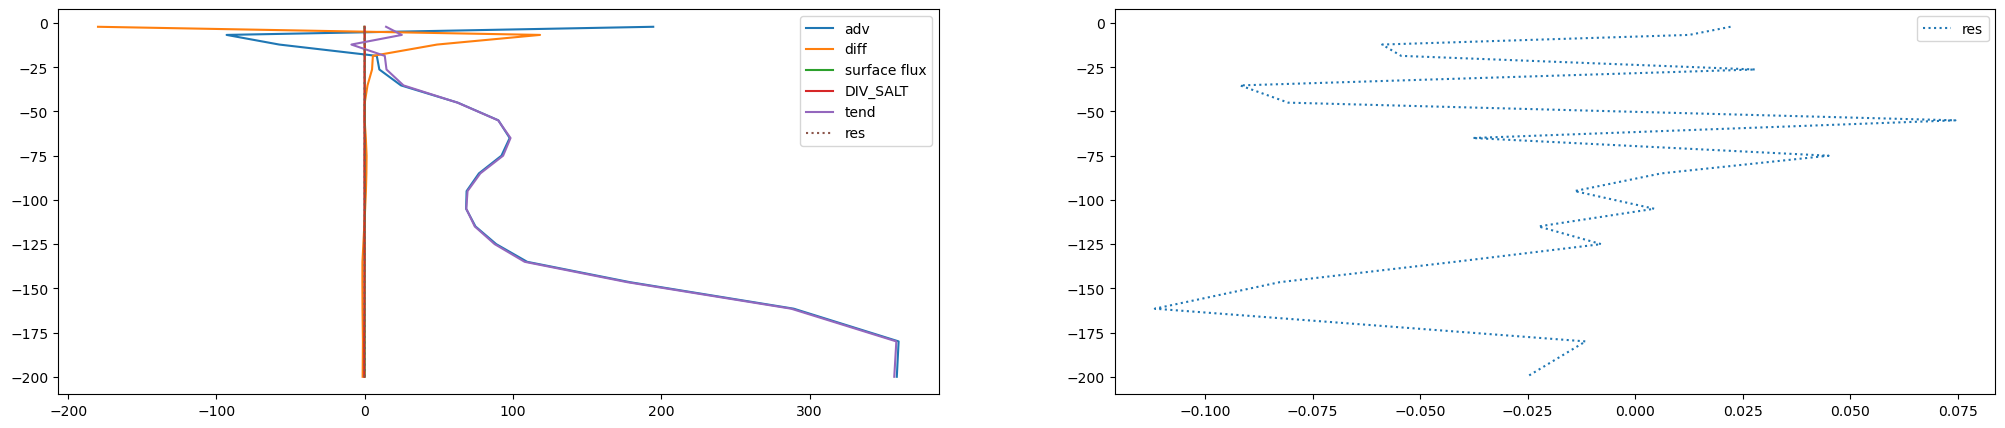

In [41]:
# Salt budget example vertical profile
# Here the salt divergence term is quite negligible

iy = 580
ix = 1200
fig, axs = plt.subplots(1,2,figsize=(25,5))
axs[0].plot(ADV_SLT.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'adv')
axs[0].plot(DIFF_SLT.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'diff')
axs[0].plot(SALTFLX.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'surface flux')
axs[0].plot(DIV_SALT.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'DIV_SALT')
axs[0].plot(SALT_TEND.isel(XC=ix, YC=iy)[:20],ds.Z[:20],label = 'tend')
axs[0].plot(RES.isel(XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'res',linestyle = ':')
axs[1].plot(RES.isel(XC=ix, YC=iy,Z=slice(20)),ds.Z[:20],label = 'res',linestyle = ':')
axs[0].legend()
axs[1].legend()
plt.show()